The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


# Sentiment Analysis and the Dataset
:label:`sec_sentiment`

Text classification is a common task in natural language processing, which transforms a sequence of text of indefinite length into a category of text. It is similar to the image classification, the most frequently used application in this book, e.g., :numref:`sec_naive_bayes`. The only difference is that, rather than an image, text classification's example is a text sentence.

This section will focus on loading data for one of the sub-questions in this field: using text sentiment classification to analyze the emotions of the text's author. This problem is also called sentiment analysis and has a wide range of applications. For example, we can analyze user reviews of products to obtain user satisfaction statistics, or analyze user sentiments about market conditions and use it to predict future trends.


In [ ]:
from d2l import mxnet as d2l
from mxnet import gluon, np, npx
import os
npx.set_np()

## The Sentiment Analysis Dataset

We use Stanford's [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) as the dataset for sentiment analysis. This dataset is divided into two datasets for training and testing purposes, each containing 25,000 movie reviews downloaded from IMDb. In each dataset, the number of comments labeled as "positive" and "negative" is equal.

###  Reading the Dataset

We first download this dataset to the "../data" path and extract it to "../data/aclImdb".


In [ ]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

Next, read the training and test datasets. Each example is a review and its corresponding label: 1 indicates "positive" and 0 indicates "negative".


In [ ]:
#@save
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: Normally the best way to annoy me in a film is to include so
label: 1 review: The Bible teaches us that the love of money is the root of a
label: 1 review: Being someone who lists Night of the Living Dead at number t


### Tokenization and Vocabulary

We use a word as a token, and then create a dictionary based on the training dataset.


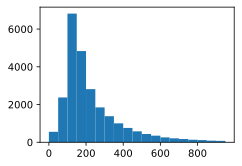

In [ ]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

d2l.set_figsize()
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

### Padding to the Same Length

Because the reviews have different lengths, so they cannot be directly combined into minibatches. Here we fix the length of each comment to 500 by truncating or adding "&lt;unk&gt;" indices.


In [ ]:
num_steps = 500  # sequence length
train_features = np.array([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
train_features.shape

(25000, 500)

### Creating the Data Iterator

Now, we will create a data iterator. Each iteration will return a minibatch of data.


In [ ]:
train_iter = d2l.load_array((train_features, train_data[1]), 64)

for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (64, 500) y (64,)


('# batches:', 391)

## Putting All Things Together

Last, we will save a function `load_data_imdb` into `d2l`, which returns the vocabulary and data iterators.


In [ ]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    data_dir = d2l.download_extract('Arts.txt', 'Arts.txt')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = np.array([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = np.array([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, train_data[1]), batch_size)
    test_iter = d2l.load_array((test_features, test_data[1]), batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## Summary

* Text classification can classify a text sequence into a category.
* To classify a text sentiment, we load an IMDb dataset and tokenize its words. Then we pad the text sequence for short reviews and create a data iterator.

## Exercises

1. Discover a different natural language dataset (such as [Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)) and build a similar data_loader function as `load_data_imdb`.


[Discussions](https://discuss.d2l.ai/t/391)
